# Process the raw Rio de Janeiro magnetic data

The data come in a bad text format and there is some cleaning and processing that we need to do:

1. Convert to standard CSV for easier reading with Pandas.
2. Convert longitude and latitude coordinates to WGS84
3. Calculate the geometric height since they only give the "distance to the ground"
4. Add projected easting and northing coordinates using a Mercator projection instead of the UTM coordinates given in 2 different zones.
5. Remove the tie lines since they seem to be a bit bad.
6. Crop the data to a smaller area with some interesting anomalies.
7. Calculate derivatives of the line data using equivalent sources.

In [1]:
import pathlib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import verde as vd
import harmonica as hm
from pyproj import Transformer
import pygmt
import xarray as xr
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Load the data

In [3]:
data_dir = pathlib.Path("..") / "data"

In [4]:
data_path = data_dir / "1038_XYZ.tar.xz"
with tarfile.open(data_path) as archive:
    with archive.extractfile("1038_XYZ/1038/spaulo_rjaneiro_rj.xyz") as data_file:
        raw_data = []
        usecols = [2, 3, 4, 18]
        read_data = False
        for i, line in enumerate(data_file):
            line = line.decode("latin1")
            if i < 5:
                continue
            if line.strip().startswith("LINE"):
                line_no = int(line.strip().split()[-1][:-1])
                read_data = True
                continue
            # Skip the tie lines because some of them are bad
            if line.strip().startswith("TIE"):
                read_data = False
                continue
            if read_data:
                columns = [float(c.strip()) for c in line.strip().split()]
                raw_data.append([columns[c] for c in usecols] + [line_no])
    full_data = pd.DataFrame(
        raw_data,
        columns=[
            "longitude",
            "latitude",
            "total_field_anomaly_nT",
            "altitude_m",
            "line_number",
        ],
    )
full_data

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0      -43.995285 -23.100388                  444.36      300.00           20
1      -43.995255 -23.099503                  434.32      300.00           20
2      -43.995224 -23.098618                  426.28      300.00           20
3      -43.995193 -23.097733                  418.24      300.00           20
4      -43.995178 -23.096832                  410.20      300.00           20
...           ...        ...                     ...         ...          ...
393290 -40.966003 -21.270996                   11.26      143.87         6500
393291 -40.965988 -21.270111                   13.17      143.87         6500
393292 -40.965988 -21.269211                   11.08      143.87         6500
393293 -40.965973 -21.268311                   11.00      143.87         6500
393294 -40.965973 -21.267426                    8.91      143.56         6500

[393295 rows x 5 columns]

## Crop the data to a better region

In [5]:
region = [-42.64, -41.9, -22.6, -22]
data = (
    full_data.loc[vd.inside((full_data.longitude, full_data.latitude), region)]
    .reset_index(drop=True)
    .copy()
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0 -42.639984 -22.290527                  -16.56      151.49         2800
1 -42.639969 -22.291397                  -43.47      162.46         2800
2 -42.639954 -22.292267                  -65.38      170.69         2800
3 -42.639938 -22.293152                  -74.29      173.43         2800
4 -42.639923 -22.294022                  -67.20      170.08         2800

## Convert coordinates from Hayford 1910 ellipsoid to WGS84 system

In [6]:
transformer = Transformer.from_crs("EPSG:4225", "EPSG:4326", always_xy=True)

data['longitude'], data['latitude'] = transformer.transform(data['longitude'].values, data['latitude'].values)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0 -42.640141 -22.290868                  -16.56      151.49         2800
1 -42.640126 -22.291738                  -43.47      162.46         2800
2 -42.640111 -22.292608                  -65.38      170.69         2800
3 -42.640095 -22.293493                  -74.29      173.43         2800
4 -42.640080 -22.294363                  -67.20      170.08         2800

## Project the coordinates

In [7]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data = data.assign(
    **{
        name: coord
        for name, coord in zip(
            ["easting_m", "northing_m"], projection(data.longitude, data.latitude)
        )
    }
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.640141 -22.290868                  -16.56      151.49         2800   
1 -42.640126 -22.291738                  -43.47      162.46         2800   
2 -42.640111 -22.292608                  -65.38      170.69         2800   
3 -42.640095 -22.293493                  -74.29      173.43         2800   
4 -42.640080 -22.294363                  -67.20      170.08         2800   

      easting_m    northing_m  
0 -4.393933e+06 -2.342247e+06  
1 -4.393932e+06 -2.342343e+06  
2 -4.393930e+06 -2.342440e+06  
3 -4.393929e+06 -2.342538e+06  
4 -4.393927e+06 -2.342634e+06

## Calculate heights

In [8]:
# orthomrtric height
topography = pygmt.datasets.load_earth_relief(resolution="01s", region=region)
topography = topography.rename({'lon': 'longitude', 'lat': 'latitude'})
# geoid height
geoid = pygmt.datasets.load_earth_geoid(resolution="01m", region=region, registration="gridline")
geoid = geoid.rename({'lon': 'longitude', 'lat': 'latitude'})

In [9]:
# Interpolate the geoid to 1s resolution
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
topography_table = vd.grid_to_table(topography)


interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.z)
topography_table = topography_table.assign(elevation=interpolator.predict((topography_table.longitude, topography_table.latitude)))

geoid_values = np.reshape(topography_table.elevation, topography.shape)
geoid = xr.DataArray(geoid_values, coords=[topography.latitude, topography.longitude], dims=['latitude', 'longitude'])

In [10]:
# geometric height
topography_geometric = topography + geoid

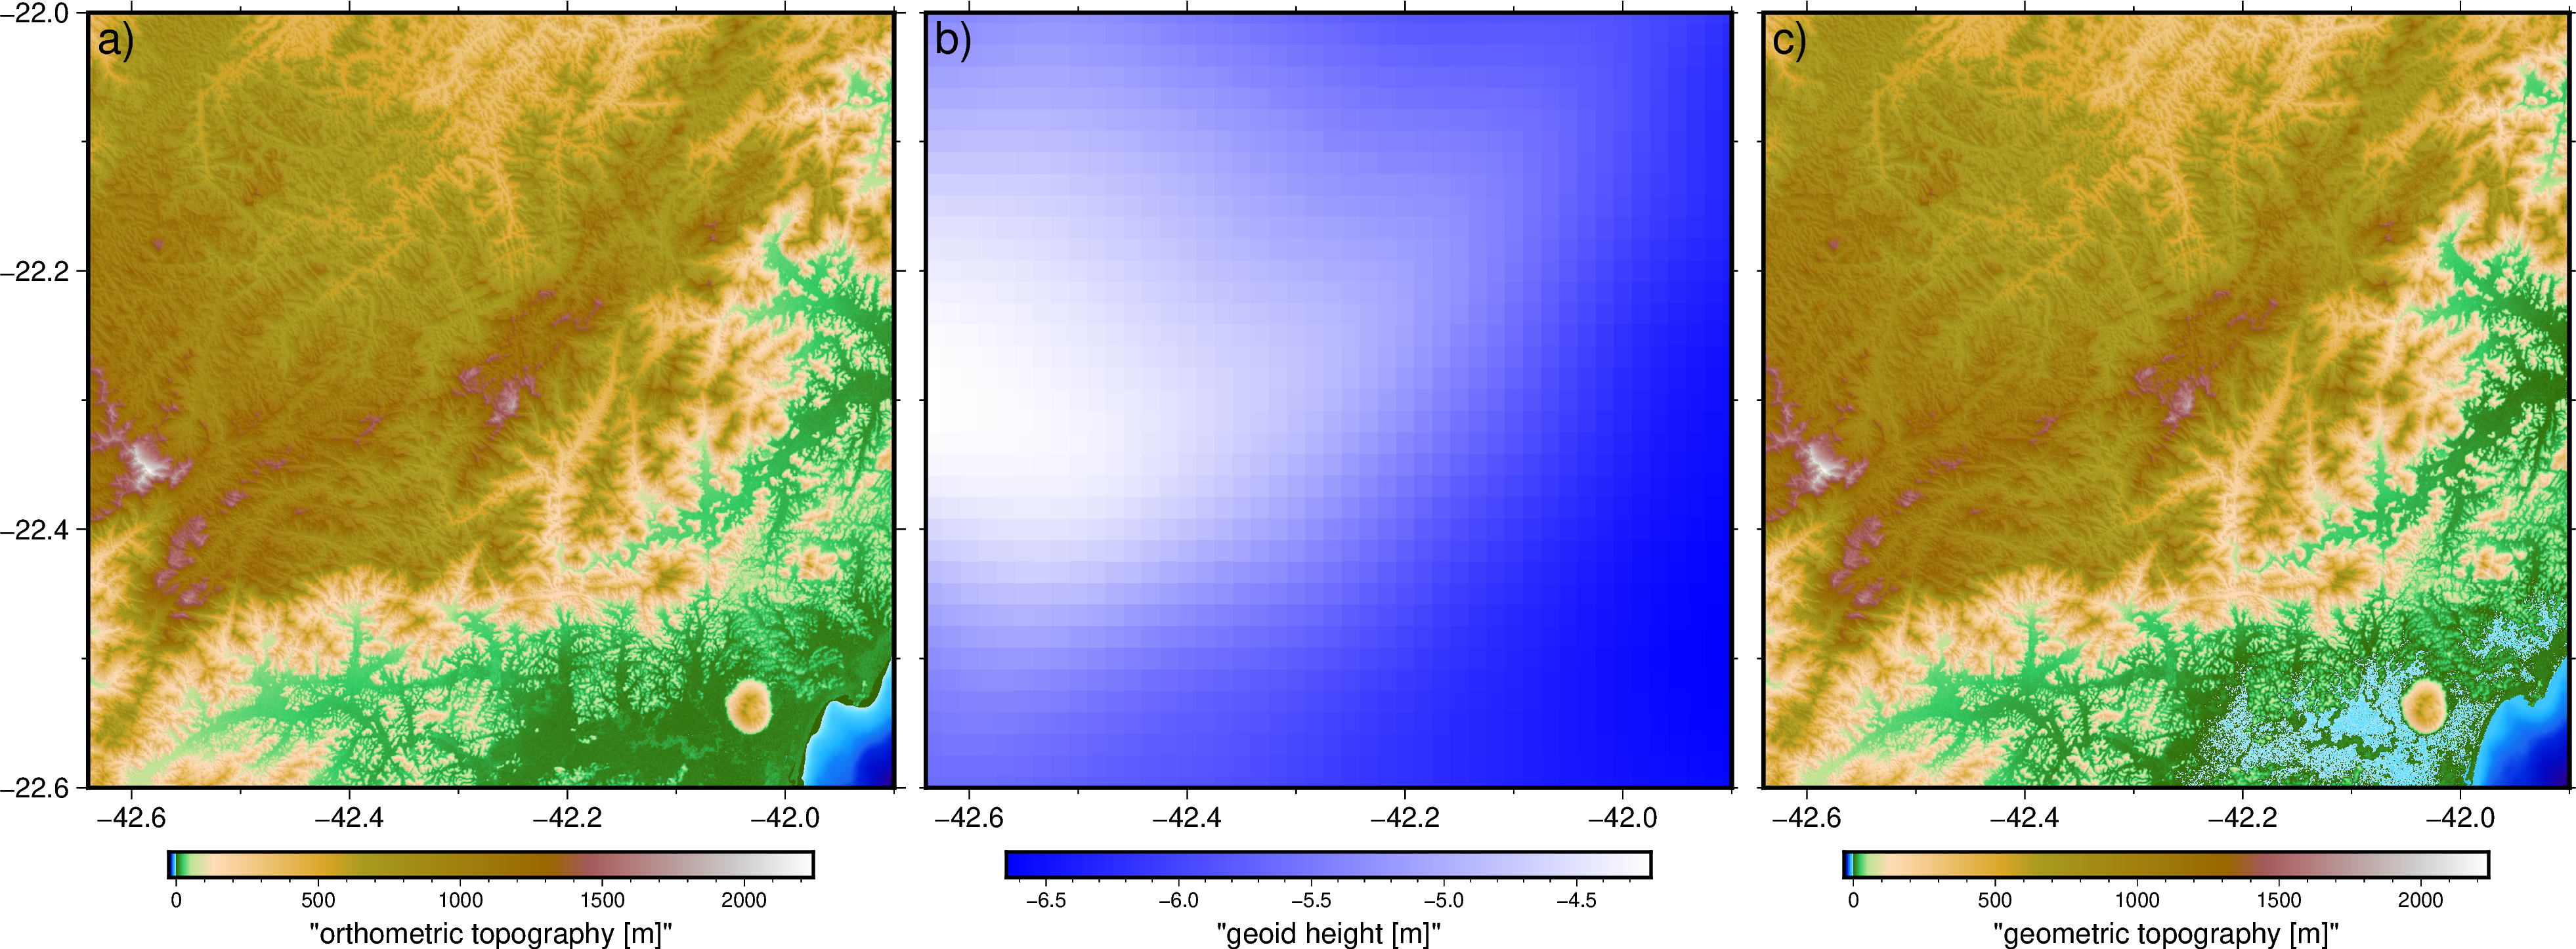

In [11]:
fig = pygmt.Figure()
with fig.subplot(
    nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
):
    with fig.set_panel(panel=0):
        
        fig.grdimage(topography, projection="X", cmap="etopo1", frame=["WSne", "xaf", "yaf"],
                    shading="+a45+nt0.15")# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
        fig.colorbar(frame='af+l"orthometric topography [m]"')


    with fig.set_panel(panel=1):
        fig.grdimage(geoid, projection="X", cmap="polar+h", frame=["WSne", "xaf", "f"])
        fig.colorbar(frame='af+l"geoid height [m]"')

    
    with fig.set_panel(panel=2):
        fig.grdimage(topography_geometric, projection="X", cmap="etopo1", frame=["WSne", "xaf", "f"],
                    shading="+a45+nt0.15")
        fig.colorbar(frame='af+l"geometric topography [m]"')

fig.show(width=1000)

In [12]:
# interpolate the geometric height in the data points
interpolator = vd.KNeighbors()

topography_geometric_table = vd.grid_to_table(topography_geometric)

interpolator.fit((topography_geometric_table.longitude, topography_geometric_table.latitude), topography_geometric_table.scalars)
data = data.assign(geometric_height_m=interpolator.predict((data.longitude, data.latitude)))
data = data.assign(geometric_flight_height_m=data.geometric_height_m+data.altitude_m)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.640141 -22.290868                  -16.56      151.49         2800   
1 -42.640126 -22.291738                  -43.47      162.46         2800   
2 -42.640111 -22.292608                  -65.38      170.69         2800   
3 -42.640095 -22.293493                  -74.29      173.43         2800   
4 -42.640080 -22.294363                  -67.20      170.08         2800   

      easting_m    northing_m  geometric_height_m  geometric_flight_height_m  
0 -4.393933e+06 -2.342247e+06             1257.78                    1409.27  
1 -4.393932e+06 -2.342343e+06             1281.78                    1444.24  
2 -4.393930e+06 -2.342440e+06             1247.78                    1418.47  
3 -4.393929e+06 -2.342538e+06             1194.78                    1368.21  
4 -4.393927e+06 -2.342634e+06             1192.78                    1362.86

## Calculate derivatives

In [13]:
%%time
eqs = hm.EquivalentSourcesGB(
    damping=1e1,
    depth=1000,
    block_size=100,
    random_state=42,
)
coordinates = (data.easting_m, data.northing_m, data.geometric_flight_height_m)
eqs.fit(coordinates, data.total_field_anomaly_nT)

CPU times: user 13min 52s, sys: 53.3 s, total: 14min 45s
Wall time: 1min 11s


EquivalentSourcesGB(block_size=100, damping=10.0, depth=1000, random_state=42)

In [14]:
delta = 5
data["deriv_up"] = (
    eqs.predict((data.easting_m, data.northing_m, data.geometric_flight_height_m + delta))
    - eqs.predict((data.easting_m, data.northing_m, data.geometric_flight_height_m - delta))
) / (2 * delta)
data["deriv_east"] = (
    eqs.predict((data.easting_m + delta, data.northing_m, data.geometric_flight_height_m))
    - eqs.predict((data.easting_m - delta, data.northing_m, data.geometric_flight_height_m))
) / (2 * delta)
data["deriv_north"] = (
    eqs.predict((data.easting_m, data.northing_m + delta, data.geometric_flight_height_m))
    - eqs.predict((data.easting_m, data.northing_m - delta, data.geometric_flight_height_m))
) / (2 * delta)

## Plot the data and derivatives

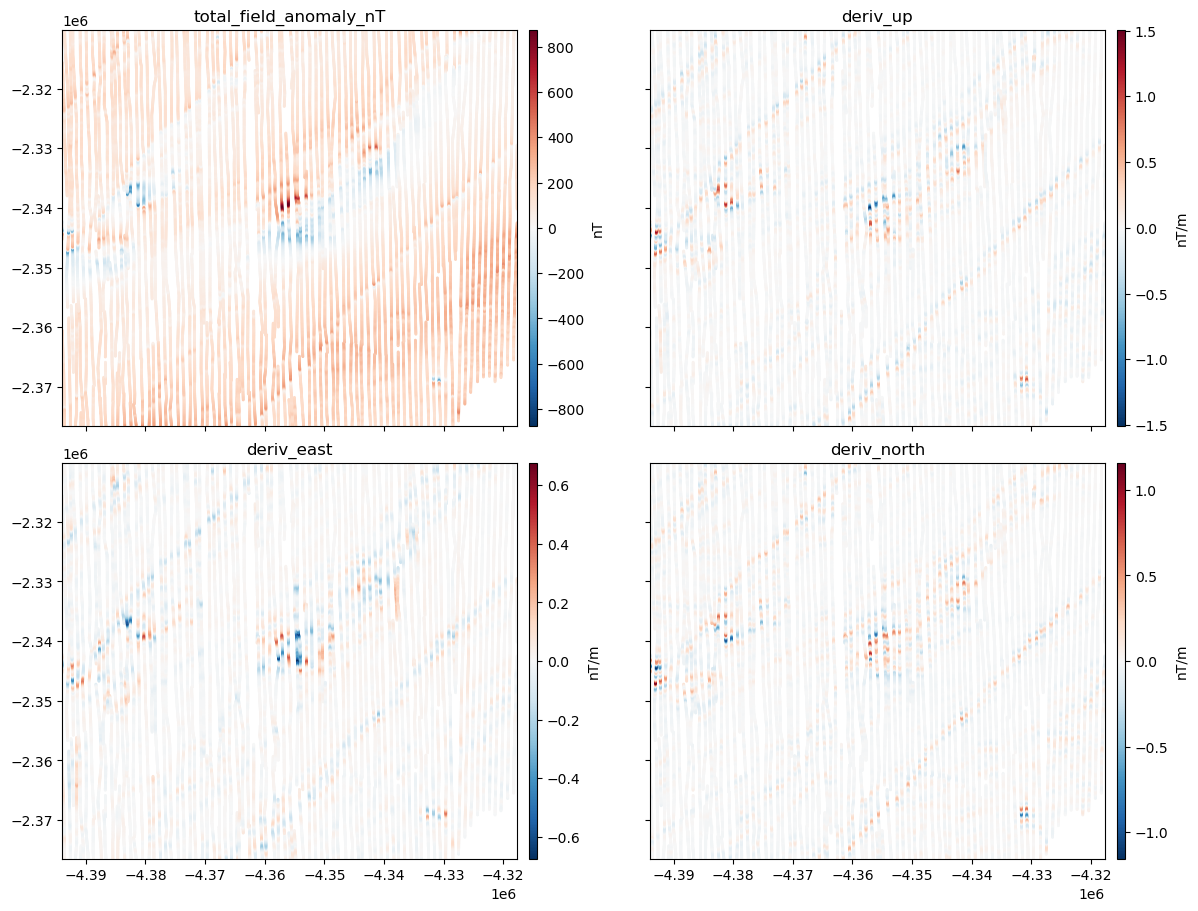

In [15]:
fig, axes = plt.subplots(
    2, 2, figsize=(12, 9), sharex=True, sharey=True, layout="constrained"
)
for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())

variables = [
    "total_field_anomaly_nT",
    "deriv_up",
    "deriv_east",
    "deriv_north",
]
units = ["nT", "nT/m", "nT/m", "nT/m"]
for ax, var, unit in zip(axes.ravel(), variables, units):
    scale = vd.maxabs(data[var])
    ax.set_title(var)
    tmp = ax.scatter(
        data.easting_m,
        data.northing_m,
        s=1,
        c=data[var],
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
    )
    fig.colorbar(tmp, ax=ax, label=unit, aspect=50, pad=0.01, orientation="vertical")
plt.show()

## Export to CSV

In [16]:
data.to_csv(data_dir / "rio-de-janeiro-magnetic.csv", index=False)